In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from diffractio.scalar_masks_X import Scalar_mask_X
%matplotlib ipympl


In [11]:
# Function to calculate the pixel coordinate that a ray hits the detector. (Used for summing ray phase for diffraction grating simulation).
def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = np.eye(2)

    y_transformed, x_transformed = (np.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)

# If we want to check that the optical path lengths that the diffraction grating and 
# lens work correctly, we can use this function to plot the "wavefront" along the rays. 
# The diffraction grating should make a new plane wave, where the new deflected wavefront is still 
# everywhere perpendicular to the rays. The lens should in general make circular wavefronts
# converging to a point in the image or focal plane. 
def interp_coordinates_from_optical_path_length(opl_0, opl_1, z_0, z_1, x_0, x_1, opl_value):
    N = len(opl_0)
    opl = np.vstack([opl_0, opl_1]).T
    z = np.vstack([z_0, z_1]).T
    x = np.vstack([x_0, x_1]).T

    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    fn_vectorized = np.vectorize(interp1d,
                                        signature='(n),(n)->()')
    # Generate array of interpolation functions for z from opl
    interp_fn_array_z_from_opl = fn_vectorized(opl, z)

    # Generate array of interpolation functions for x from z
    interp_fn_array_x_from_z = fn_vectorized(z, x)

    # Initialize arrays for results
    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    # Evaluate the interpolated values
    for i in range(N):
        z_given_opl[i] = interp_fn_array_z_from_opl[i](opl_value)
        x_given_z[i] = interp_fn_array_x_from_z[i](z_given_opl[i])
        
    return z_given_opl, x_given_z

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x1 - x0
    vy = y1 - y0
    vz = z1 - z0
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N

# Function to propagate a distance z, and obtain the new optical path length. 
def propagate(x, y, z, L, M, N, d, opl):
    dx = (L / N) * d
    dy = (M / N) * d
    dz = (N / N) * d
    x1 = x + dx
    y1 = y + dy
    z1 = z + dz
    
    opl_out = opl + np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return x1, y1, z1, opl_out

def rotation_matrix(x, y, cx, cy, alpha):
    x0 = x - cx
    y0 = y - cy
    x0_rot = x0 * np.cos(alpha) - y0 * np.sin(alpha)
    y0_rot = x0 * np.sin(alpha) + y0 * np.cos(alpha)
    x1_rot = x0_rot + cx
    y1_rot = y0_rot + cy
    return x1_rot, y1_rot

In [12]:
# Essentially the code as sent from Jeffrey
def perfect_lens(u1, v1, L1, M1, N1, f, m_p, opl_in):
    
    '''
    The following parameters are taken as inputs:

    (u1, v1):  incoming ray intercept coordinates (1st principal plane)
    (l1, m1, n1):  incoming ray direction cosines

    f:  lens focal length
    m_p: transverse paraxial magnfication
    
    opl_in: Optical path length of input ray at 1st principal plane of lens
    '''
    # Initial Numerical Aperture
    NA1 = 0.1
    NA2 = 0.1
    
    # Check if magnification is too small or large, and thus a finite-long conjugate approximation
    # is applied
    if np.abs(m_p) <= 1e-10:
        z1 = -1e10
        z2 = f
    elif np.abs(m_p) > 1e10:
        z1 = -f
        z2 = 1e10
    else:
        z1 = f * (1/m_p - 1)
        z2 = f * (1 - m_p)
    
    # If so, we need to set the signal that the numerical aperture is 
    # 0.0, neccessary for later
    if np.abs(z1) >= 1e10:
        z1 = 1e10 * (z1 / np.abs(z1))
        NA1 = 0.0  #collimated input
        
    if np.abs(z2) >= 1e10:
        z2 = 1e10 * (z2 / np.abs(z2))
        NA2 = 0.0  #collimated input
    
    m_p = z2 / z1
    
    # Ray object point coordinates (x1, y1) on front conjugate plane
    if (NA1 == 0.0):
        x1 = (L1 / N1) * z1
        y1 = (M1 / N1) * z1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        L1_est = -(x1 - u1) / r1_mag
        M1_est = -(y1 - v1) / r1_mag
    else:
        
        x1 = (L1 / N1) * z1 + u1
        y1 = (M1 / N1) * z1 + v1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
    
    # Principal Ray directions
    if (NA1 == 0.0):
        L1_p = L1
        M1_p = M1
        N1_p = N1
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
    else:
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L1_p = (x1 / p1_mag) * z1 / np.abs(z1)
        M1_p = (y1 / p1_mag) * z1 / np.abs(z1)
        N1_p = np.sqrt(1 - L1_p ** 2 - M1_p ** 2)
    
    # Coordinates in image plane or focal plane
    if np.abs(m_p) <= 1.0:
        x2 = z2 * (L1_p / N1_p)
        y2 = z2 * (M1_p / N1_p)
        
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        L2_p = (x2 / p2_mag) * (z2 / np.abs(z2))
        M2_p = (y2 / p2_mag) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
    else:
        a = x1 / z1
        b = y1 / z1
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
    
    # Calculation to back propagate to right hand side principal plane
    Cx = m_p * L2_p - L1_p
    Cy = m_p * M2_p - M1_p  
    
    if (NA1 == 0.0):
        L2 = (L1_est + Cx) / m_p
        M2 = (M1_est + Cy) / m_p
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    else:
        L2 = (L1 + Cx) / m_p
        M2 = (M1 + Cy) / m_p
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    
    # We use a mask to find rays that have gone to the centre,
    # because we are not inputting one ray at a time, but a vector of rays. 
    mask = np.sqrt(u1 ** 2 + v1 ** 2) < 1e-7
    
    # Initialize the output arrays
    u2 = np.zeros_like(u1)
    v2 = np.zeros_like(v1)

    # Handle the case where the mask is true and NA2 = 0.0
    if NA2 == 0.0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p

        L2[mask] = L2_p[mask]
        M2[mask] = M2_p[mask]
        N2[mask] = N2_p[mask]
        u2[mask] = 0.0
        v2[mask] = 0.0

    # For the case where the mask is false, (rays are not going through the centre of the lens)
    not_mask = ~mask
    u2[not_mask] = -(L2[not_mask] / N2[not_mask]) * z2 + x2[not_mask]
    v2[not_mask] = -(M2[not_mask] / N2[not_mask]) * z2 + y2[not_mask]

    if NA2 == 0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p

        L2[not_mask] = L2_p[not_mask]
        M2[not_mask] = M2_p[not_mask]
        N2[not_mask] = N2_p[not_mask]

    # Calculate final distance from image/focal plane to point ray leaves lens for optical path length
    # calculation
    r2_mag = np.sqrt((x2 - u2) ** 2 + (y2 - v2) ** 2 + z2 ** 2)
    
    opl1 = r1_mag + r2_mag # Ray opl
    opl0 = p1_mag + p2_mag # Principal ray opl
    
    opl = opl_in + (opl0 - opl1)

    return u2, v2, L2, M2, N2, opl


In [13]:
def fourier_lens(u1, v1, L1, M1, N1, f, m_p, opl_in):
    tol = 1e-15
    '''
    The following parameters are taken as inputs:

    (u1, v1):  incoming ray intercept coordinates (1st principal plane)
    (l1, m1, n1):  incoming ray direction cosines

    f:  lens focal length
    m_p: transverse paraxial magnfication
    
    opl_in: Optical path length of input ray at 1st principal plane of lens
    '''
    # Initialise numerical aperture
    NA1 = 0.1
    NA2 = 0.1
    
    # Check if magnification is too small or large, and thus a finite-long conjugate approximation
    # is applied
    if np.abs(m_p) <= 1e-10:
        z1 = -1e10
        z2 = f
    elif np.abs(m_p) > 1e10:
        z1 = -f
        z2 = 1e10
    else:
        z1 = f * (1/m_p - 1)
        z2 = f * (1 - m_p)
    
    m_p = z2 / z1

    ''' Comment from Jeffrey Wilde: Check again for infinite conjugates, but this time use z1, z2.  It's possible that some values
    of M exist for the "finite conjugate" case above that may lead to z1 or z2 outside of the +/-1e10 limits, 
    so we should treat such instances as infinite conjugate and therefore force z1,z2 to remain bounded 
    at our desired  +/-1e10 limits. '''
    if np.abs(z1) >= 1e10:
        z1 = 1e10 * (z1 / np.abs(z1))
        NA1 = 0.0  #collimated input
        
    if np.abs(z2) >= 1e10:
        z2 = 1e10 * (z2 / np.abs(z2))
        NA2 = 0.0  #collimated input
        
    # Ray object point coordinates (x1, y1) on front conjugate plane
    if (NA1 == 0.0):
        x1 = (L1 / N1) * z1
        y1 = (M1 / N1) * z1
        
        xy_alpha = -np.arctan2(y1, x1) + np.pi / 2
        
        # Rotate x1, y1 and L1, M1 onto y axis
        x1, y1 = rotation_matrix(x1, y1, 0, 0, xy_alpha)
        L1, M1 = rotation_matrix(L1, M1, 0, 0, xy_alpha)
        u1, v1 = rotation_matrix(u1, v1, 0, 0, xy_alpha)

        # We also numerically calculate dx and dy for abbe sine condition later
        dx1 = x1 + (z1 / 1000)
        dy1 = y1 + (z1 / 1000)
        
        # Get distance from object point to image point
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        # Find extimate for infinite front conjugate case
        L1_est = - (x1 - u1) / r1_mag
        M1_est = - (y1 - v1) / r1_mag
    else:

        x1 = (L1 / N1) * z1 + u1
        y1 = (M1 / N1) * z1 + v1
        
        xy_alpha = -np.arctan2(y1, x1) + np.pi / 2
        
        # Rotate x1, y1 and L1, M1 onto y axis
        x1, y1 = rotation_matrix(x1, y1, 0, 0, xy_alpha)
        L1, M1 = rotation_matrix(L1, M1, 0, 0, xy_alpha)
        u1, v1 = rotation_matrix(u1, v1, 0, 0, xy_alpha)
        
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        #Numerical solution to dx and dy of lens
        dx1 = x1 + (z1 / 1000)
        dy1 = y1 + (z1 / 1000)
    
    # Obtain direction cosines of incoming principal ray
    if (NA1 == 0.0):
        L1_p = L1
        M1_p = M1
        
        dL1_p = L1
        dM1_p = M1
        
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        dp1_mag = np.sqrt(dx1 ** 2 + dy1 ** 2 + z1 ** 2)
    else:
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        dp1_mag = np.sqrt(dx1 ** 2 + dy1 ** 2 + z1 ** 2)
    
        L1_p = (x1 / p1_mag) * z1 / np.abs(z1)
        M1_p = (y1 / p1_mag) * z1 / np.abs(z1)
        
        dL1_p = (dx1 / dp1_mag) * z1 / np.abs(z1)
        dM1_p = (dy1 / dp1_mag) * z1 / np.abs(z1)
        
    # Obtain positions of ray in image plane, and direction cosines of outgoing principal ray
    if np.abs(m_p) <= 1.0:
        x2 = z2 * (L1_p)
        y2 = z2 * (M1_p)
        
        #Numerical solution to dx and dy of lens
        dx2 = z2 * dL1_p 
        dy2 = z2 * dM1_p
        
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        L2_p = (x2 / p2_mag) * (z2 / np.abs(z2))
        M2_p = (y2 / p2_mag) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    else:
        L2_p = (x1 / z1) * (z2 / np.abs(z2))
        M2_p = (y1 / z1) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        #Numerical solution to dx and dy of len
        dL2_p = (dx1 / z1) * (z2 / np.abs(z2))
        dM2_p = (dy1 / z1) * (z2 / np.abs(z2))
        dN2_p = np.sqrt(1 - dL2_p ** 2 - dM2_p ** 2)
        
        dx2 = (dL2_p / dN2_p) * z2
        dy2 = (dM2_p / dN2_p) * z2
        
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
    
    # Calculate ray positions in second principal plane of lens using numerical approximation
    # of the abbe sine condition
    mdx = dx2 / dx1
    mdy = dy2 / dy1
    
    # If mdx or mdy are below tol, then 
    mask_mdx = np.abs(mdx) < tol
    mask_mdy = np.abs(mdy) < tol
    
    mdx[mask_mdx] = m_p
    mdy[mask_mdy] = m_p
        
    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p  
    
    if (NA1 == 0.0):
        L2 = (L1_est + Cx) / mdx
        M2 = (M1_est + Cy) / mdy
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    else:
        L2 = (L1 + Cx) / mdx
        M2 = (M1 + Cy) / mdy
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    
    # For rays that go through centre of lens, we need to treat them separately 
    # Calculate the mask for this condition - 
    mask = np.sqrt(u1 ** 2 + v1 ** 2) < 1e-7

    # Initialize the output arrays
    u2 = np.zeros_like(u1)
    v2 = np.zeros_like(v1)

    # Handle the case where the mask is true and NA2 = 0.0 (rays go through centre of lens)
    if NA2 == 0.0:
        a = -x1 / f
        b = -y1 / f
        
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p * (z2 / np.abs(z2))
        M2_p = b * N2_p * (z2 / np.abs(z2))

        L2[mask] = L2_p[mask]
        M2[mask] = M2_p[mask]
        N2[mask] = N2_p[mask]
        u2[mask] = 0.0
        v2[mask] = 0.0

    # Apply the rotation_matrix function
    L2[mask], M2[mask] = rotation_matrix(L2[mask], M2[mask], 0., 0., -xy_alpha[mask])
    x2[mask], y2[mask] = rotation_matrix(x2[mask], y2[mask], 0., 0., -xy_alpha[mask])

    # For the case where the mask is false (rays don't go through centre of lens)
    not_mask = ~mask
    
    if NA2 == 0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p * (z2 / np.abs(z2))
        M2_p = b * N2_p * (z2 / np.abs(z2))

        L2[not_mask] = L2_p[not_mask]
        M2[not_mask] = M2_p[not_mask]
        N2[not_mask] = N2_p[not_mask]
        
    L2[not_mask], M2[not_mask] = rotation_matrix(L2[not_mask], M2[not_mask], 0., 0., -xy_alpha[not_mask])
    x2[not_mask], y2[not_mask] = rotation_matrix(x2[not_mask], y2[not_mask], 0., 0., -xy_alpha[not_mask])
    
    u2[not_mask] = -(L2[not_mask] / N2[not_mask]) * z2 + x2[not_mask]
    v2[not_mask] = -(M2[not_mask] / N2[not_mask]) * z2 + y2[not_mask]

    # Calculate final distance from image/focal plane to point ray leaves lens for optical path length
    # calculation
    r2_mag = np.sqrt((x2 - u2) ** 2 + (y2 - v2) ** 2 + z2 ** 2)
    
    opl1 = r1_mag + r2_mag # Ray opl
    opl0 = p1_mag + p2_mag # Principal ray opl
    
    opl = opl_in + (opl0 - opl1)
    
    return u2, v2, L2, M2, N2, opl

In [14]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -6
f = 10

# Choose z positions to plot based on magnification
if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
elif np.abs(m_p) > 1e10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

print(z1, z2)
N = 5

# Define x and y coordinates of ray starting positions
x1 = np.linspace(0, 0, N)
y1 = np.linspace(7, 7, N)
z1 = np.linspace(z1, z1, N)

# angles = np.linspace(-10, 10, N)

# Generate uniform spherical coordinates
theta = np.linspace(1, 1, 1)  # polar angle
phi = np.linspace(0, 2 * np.pi, N)  # azimuthal angle
theta, phi = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian coordinates
L1 = np.sin(theta) * np.cos(phi)  # x direction cosine
M1 = np.sin(theta) * np.sin(phi)  # y direction cosine
N1 = np.cos(theta)  # z direction cosine

# Flatten the arrays to get vectors of direction cosines
L1 = L1.flatten()
M1 = M1.flatten()
N1 = N1.flatten()

# Obtain the location where the ray hits the first principal plane
u1 = - (L1 / N1) * z1 + x1
v1 = - (M1 / N1) * z1 + y1

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

-11.666666666666668 70


In [15]:
# Calculate OPL at lens
opl_in = np.zeros(N)
opl_l = opl_in + np.sqrt(((M1 / N1) * z1) ** 2 + z1 ** 2)

u2, v2, L2, M2, N2, opl = fourier_lens(u1, v1, L1, M1, N1, f, m_p, opl_in)

# Calculate ray position in image plane
x2, y2 = u2 + (L2 / N2) * z2, v2 + (M2 / N2) * z2
print(x2, y2)

# And new OPL
opl_r = opl_l + opl
opl_focal = opl_r + np.sqrt(((M2 / N2) * z2) ** 2 + z2 ** 2)

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

[0. 0. 0. 0. 0.] [-52.5 -52.5 -52.5 -52.5 -52.5]


(-18.97348134390107,
 77.3068146772344,
 -56.87637709186978,
 39.40391892926569,
 -36.10511100792581,
 36.10511100792581)

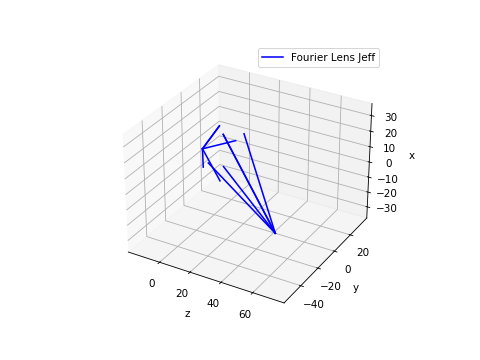

In [16]:
# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # Plotting the lines for each point
for i in range(N):
    ax.plot([z1[i] + pp_1s[i], pp_1s[i]], [y1[i], v1[i]], [x1[i], u1[i]], '-b')
    ax.plot([pp_2s[i], z2s[i] + pp_2s[i]], [v2[i], y2[i]], [u2[i], x2[i]], '-b')

ax.plot([], [], '-b', label = 'Fourier Lens Jeff')
ax.axis('equal')
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')
ax.legend()
ax.axis('equal')

In [17]:
# Calculate OPL at lens
opl_in = np.zeros(N)
opl_l = opl_in + np.sqrt(((M1 / N1) * z1) ** 2 + z1 ** 2)

u2, v2, L2, M2, N2, opl = perfect_lens(u1, v1, L1, M1, N1, f, m_p, opl_in)

# Calculate ray position in image plane
x2, y2 = u2 + (L2 / N2) * z2, v2 + (M2 / N2) * z2

print(x2, y2)
# And new OPL
opl_r = opl_l + opl
opl_focal = opl_r + np.sqrt(((M2 / N2) * z2) ** 2 + z2 ** 2)

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

[0. 0. 0. 0. 0.] [-42. -42. -42. -42. -42.]


In [18]:

# Plotting the lines for each point
for i in range(N):
    ax.plot([z1[i] + pp_1s[i], pp_1s[i]], [y1[i], v1[i]], [x1[i], u1[i]], '-g')
    ax.plot([pp_2s[i], z2s[i] + pp_2s[i]], [v2[i], y2[i]], [u2[i], x2[i]], '-g')

ax.plot([], [], '-g', label = 'Perfect Lens Jeff')
ax.axis('equal')
ax.set_xlabel('z')
ax.set_ylabel('y')
ax.set_zlabel('x')
ax.legend()
ax.axis('equal')

(-19.028013318331745,
 77.36134665166507,
 -56.88133454409075,
 39.50802542590607,
 -36.14600998874881,
 36.14600998874881)